Imports and setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/Msc AI/Practical Work/COATI')
#os.chdir('/content/drive/MyDrive/Msc AI/COATI')

In [1]:
!pip install rdkit
!pip install boto3
!pip install pytorch-ignite
!pip install gpytorch
!pip install git+https://github.com/y0ast/DUE.git
!pip install git+https://github.com/ml-jku/clamp

  Using cached rdkit-2023.9.6-cp39-cp39-macosx_10_13_x86_64.whl.metadata (3.9 kB)
Using cached rdkit-2023.9.6-cp39-cp39-macosx_10_13_x86_64.whl (28.7 MB)
  Cloning https://github.com/y0ast/DUE.git to /private/var/folders/h5/sfz06yh5207339s992l9zwc80000gn/T/pip-req-build-mgotpl70
  Running command git clone --filter=blob:none --quiet https://github.com/y0ast/DUE.git /private/var/folders/h5/sfz06yh5207339s992l9zwc80000gn/T/pip-req-build-mgotpl70
  Resolved https://github.com/y0ast/DUE.git to commit f29c990811fd6a8e76215f17049e6952ef5ea0c9
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/ml-jku/clamp to /private/var/folders/h5/sfz06yh5207339s992l9zwc80000gn/T/pip-req-build-livhmhep
  Running command git clone --filter=blob:none --quiet https://github.com/ml-jku/clamp /private/var/folders/h5/sfz06yh5207339s992l9zwc80000gn/T/pip-req-build-livhmhep
  Resolved https://github.com/ml-jku/clamp to commit f357f703d5335715d2368fdc66cb4069b33a93a8
  Preparing metadata (setup.py

In [10]:
import sys

# Specify the path to be added
path_to_add = '/teamspace/studios/this_studio/COATI'

# Check if the path is already in sys.path to avoid duplicates
if path_to_add not in sys.path:
    sys.path.append(path_to_add)

# Optional: print sys.path to confirm the path has been added
print(sys.path)

['/teamspace/studios/this_studio', '/teamspace/studios/this_studio/COATI/examples/simple_mol_generation', '/home/zeus/miniconda3/envs/cloudspace/lib/python310.zip', '/home/zeus/miniconda3/envs/cloudspace/lib/python3.10', '/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/lib-dynload', '', '/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages', '/teamspace/studios/this_studio/COATI']


In [3]:
# COATI Imports
import pickle
import numpy as np
from rdkit import Chem
import rdkit.Chem.QED
import torch
from coati.models.io.coati import load_e3gnn_smiles_clip_e2e
from coati.models.regression.basic_due import basic_due
from coati.common.util import batch_indexable

# CLAMP Imports
import torch
import clamp

#DEVICE = torch.device("cuda:0")

AttributeError: module 'pandas.io.formats.format' has no attribute 'get_adjustment'

##Load models

### COATI

In [12]:
coati_encoder, coati_tokenizer = load_e3gnn_smiles_clip_e2e(
    freeze=True,
    device=DEVICE,
    # barlowmol
    doc_url="s3://terray-public/models/barlow_closed.pkl",
)

Loading model from s3://terray-public/models/barlow_closed.pkl


File downloaded successfully to ./models/barlow_closed.pkl
Loading tokenizer may_closedparen from s3://terray-public/models/barlow_closed.pkl
number of parameters: 12.64M
number of parameters Total: 2.44M xformer: 17.92M Total: 20.36M 
vocab_name not found in tokenizer_vocabs, trying to load from file
Freezing encoder
20561664 params frozen!


### CLAMP

In [13]:
clamp_model = clamp.CLAMP(device='cpu')
clamp_model.eval()

clamp_model

2024-06-17 10:27:30.180 | INFO     | clamp.models.pretrained:download_weights_if_not_present:46 - Downloading checkpoint.pt from https://cloud.ml.jku.at/s/7nxgpAQrTr69Rp2/download/checkpoint.pt to data/models/clamp_clip
--2024-06-17 10:27:30--  https://cloud.ml.jku.at/s/7nxgpAQrTr69Rp2/download/checkpoint.pt
Resolving cloud.ml.jku.at (cloud.ml.jku.at)... 140.78.90.41
Connecting to cloud.ml.jku.at (cloud.ml.jku.at)|140.78.90.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 667072057 (636M) [application/octet-stream]
Saving to: ‘data/models/clamp_clip/checkpoint.pt’

     0K .......... .......... .......... .......... ..........  0%  236K 45m55s
    50K .......... .......... .......... .......... ..........  0%  474K 34m25s
   100K .......... .......... .......... .......... ..........  0% 62.6M 23m0s
   150K .......... .......... .......... .......... ..........  0%  477K 22m56s
   200K .......... .......... .......... .......... ..........  0% 91.1M 18m22s
 

PretrainedCLAMP(
  (compound_encoder): NetworkLayerNorm(
    (linear_input): Linear(in_features=8192, out_features=4096, bias=True)
    (linear_hidden_l): ModuleList(
      (0): Linear(in_features=4096, out_features=2048, bias=True)
    )
    (linear_output): Linear(in_features=2048, out_features=768, bias=True)
    (normalization_input): LayerNorm((4096,), eps=1e-05, elementwise_affine=False)
    (normalization_hidden_l): ModuleList(
      (0): LayerNorm((2048,), eps=1e-05, elementwise_affine=False)
    )
    (nonlinearity): ReLU()
    (dropout_input): Dropout(p=0.1, inplace=False)
    (dropout_hidden): Dropout(p=0.2, inplace=False)
  )
  (assay_encoder): NetworkLayerNorm(
    (linear_input): Linear(in_features=512, out_features=4096, bias=True)
    (linear_hidden_l): ModuleList(
      (0): Linear(in_features=4096, out_features=2048, bias=True)
    )
    (linear_output): Linear(in_features=2048, out_features=768, bias=True)
    (normalization_input): LayerNorm((4096,), eps=1e-05, elem

In this example, we work with a subset from the Chembl dataset.

In [14]:
import random

from coati.common.s3 import cache_read

# load Chembl dataset smile strings.
with cache_read("s3://terray-public/datasets/chembl_canonical_smiles.pkl", "rb") as f:
    chembl_canonical_smiles = pickle.loads(f.read(), encoding="UTF-8")

# for our example, we will use a small subset of the data
random.shuffle(chembl_canonical_smiles)
chembl_subset = chembl_canonical_smiles[:10_000]
#print(chembl_canonical_smiles[0])
chembl_subset = [{"smiles": s, "source": "chembl_mols"} for s in chembl_canonical_smiles]
print(len(chembl_subset))

2177805


In [9]:
def embed_and_score_in_batches(
    records,
    model_name='coati',
    encoder=coati_encoder,
    tokenizer=coati_tokenizer,
    batch_size=128,
    score=True,
    smiles_field="smiles",
):
    # A helper function to compute embeddings from the model encoder and
    # rdkit properties of molecules in batches. The input list of dict records
    # is modified in place.

    print("Embedding and scoring iterable from smiles.")
    batch_iter = batch_indexable(records, batch_size)
    num_batches = len(records) // batch_size
    with torch.no_grad():
        for i, batch in enumerate(batch_iter):
            print(f"batch: {i}/{num_batches}")
            if model_name == 'coati':
              try:
                  batch_mols = [Chem.MolFromSmiles(row[smiles_field]) for row in batch]
                  batch_smiles = [Chem.MolToSmiles(m) for m in batch_mols]
                  batch_tokens = torch.tensor(
                      [
                          tokenizer.tokenize_text("[SMILES]" + s + "[STOP]", pad=True)
                          if s != "*"
                          else tokenizer.tokenize_text("[SMILES]C[STOP]", pad=True)
                          for s in batch_smiles
                      ],
                      device=encoder.device,
                      dtype=torch.int,
                  )
                  #print(batch_tokens[0])
                  batch_embeds = encoder.encode_tokens(batch_tokens, tokenizer)
                  #print(batch_embeds[0]) #1x256
                  if score:
                      batch_logp = [rdkit.Chem.Crippen.MolLogP(m) for m in batch_mols]
                      batch_qed = [rdkit.Chem.QED.qed(m) for m in batch_mols]
                  if len(batch) < 2:
                      batch[0]["emb_smiles"] = batch_embeds[0].detach().cpu().numpy()
                      if score:
                          batch[0]["qed"] = batch_qed[0]
                          batch[0]["logp"] = batch_logp[0]
                          batch[0]["smiles"] = batch_smiles[0]
                  else:
                      for k, r in enumerate(batch):
                          batch[k]["emb_smiles"] = batch_embeds[k].detach().cpu().numpy()
                          if score:
                              batch[k]["qed"] = batch_qed[k]
                              batch[k]["logp"] = batch_logp[k]
                              batch[k]["smiles"] = batch_smiles[k]
              except Exception as Ex:
                  print(Ex)
                  continue

            if model_name == 'clamp':
              try:
                  batch_mols = [Chem.MolFromSmiles(row[smiles_field]) for row in batch]
                  batch_smiles = [Chem.MolToSmiles(m) for m in batch_mols]
                  batch_tokens = [s if s != '*' else 'C' for s in batch_smiles]
                  batch_embeds = encoder.encode_smiles(batch_tokens)
                  #print(batch_embeds[0]) #1x768
                  if score:
                      batch_logp = [rdkit.Chem.Crippen.MolLogP(m) for m in batch_mols]
                      batch_qed = [rdkit.Chem.QED.qed(m) for m in batch_mols]
                  if len(batch) < 2:
                      batch[0]["emb_smiles"] = batch_embeds[0].detach().cpu().numpy()
                      if score:
                          batch[0]["qed"] = batch_qed[0]
                          batch[0]["logp"] = batch_logp[0]
                          batch[0]["smiles"] = batch_smiles[0]
                  else:
                      for k, r in enumerate(batch):
                          batch[k]["emb_smiles"] = batch_embeds[k].detach().cpu().numpy()
                          if score:
                              batch[k]["qed"] = batch_qed[k]
                              batch[k]["logp"] = batch_logp[k]
                              batch[k]["smiles"] = batch_smiles[k]
              except Exception as Ex:
                  print(Ex)
                  continue

    return records

For our subset, we compute the embeddings from the model encoder for the given molecule smile string and the RDKit properties: LogP and quantitative estimate of druglikeness (QED). These quantities are added to `chembl_subset` in place.

In [ ]:
# embed and score the dataset in batches and in place.
embeddings_coati = embed_and_score_in_batches(chembl_subset, model_name='coati', encoder=coati_encoder, tokenizer=coati_tokenizer)

Embedding and scoring iterable from smiles.
batch: 0/17014
batch: 1/17014
batch: 2/17014
batch: 3/17014
batch: 4/17014
batch: 5/17014
batch: 6/17014
batch: 7/17014
batch: 8/17014
batch: 9/17014
batch: 10/17014
batch: 11/17014
batch: 12/17014
batch: 13/17014
batch: 14/17014
batch: 15/17014
batch: 16/17014
batch: 17/17014
batch: 18/17014
batch: 19/17014
batch: 20/17014
batch: 21/17014
batch: 22/17014
batch: 23/17014
batch: 24/17014
batch: 25/17014
batch: 26/17014
batch: 27/17014
batch: 28/17014
batch: 29/17014
batch: 30/17014
batch: 31/17014
batch: 32/17014
batch: 33/17014
batch: 34/17014
batch: 35/17014
batch: 36/17014
batch: 37/17014
batch: 38/17014
batch: 39/17014
batch: 40/17014
batch: 41/17014
batch: 42/17014
batch: 43/17014
batch: 44/17014
batch: 45/17014
batch: 46/17014
batch: 47/17014
batch: 48/17014
batch: 49/17014
batch: 50/17014
batch: 51/17014
batch: 52/17014
batch: 53/17014
batch: 54/17014
batch: 55/17014
batch: 56/17014
batch: 57/17014
batch: 58/17014
batch: 59/17014
batch:

In [ ]:
embeddings_clamp = embed_and_score_in_batches(chembl_subset, model_name='clamp', encoder=clamp_model)

Train a DUE regression model. We first regress the RDKit-calculated QED score for our subset. Please refer to `coati/models/regression/basic_due.py` for implementation details and background.

In [ ]:
coati_qed_model, coati_qed_res = basic_due(
    embeddings_coati,
    x_field="emb_smiles",
    y_field="qed",
    continue_training=True,
    steps=1e4,
)
coati_qed_model = coati_qed_model.to(DEVICE)

In [ ]:
clamp_qed_model, clamp_qed_res = basic_due(
    embeddings_clamp,
    x_field="emb_smiles",
    y_field="qed",
    continue_training=True,
    steps=1e4,
)
clamp_qed_model = clamp_qed_model.to(DEVICE)

Visualize the output from the trained DUE model.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from coati.math_tools.altair_plots import roc_plot

sns.set()
sns.set_palette("colorblind")


def get_due_plot(due_result, y_field="qed"):
    """Plots the DUE model regressed results."""

    # xs are the true values, ys are the predicted values, dys are the errors.
    xs, ys, dys = due_result

    fig, ax = plt.subplots(figsize=(11, 6))
    n_to_plot = 30000
    plt.style.use("seaborn-whitegrid")
    ax.errorbar(
        (xs[:n_to_plot]),
        (ys[:n_to_plot]),
        yerr=dys[:n_to_plot],
        fmt="o",
        color="black",
        ecolor="lightgray",
        elinewidth=3,
        capsize=0,
    )
    plt.xlabel("True " + y_field)
    plt.ylabel("Regressed " + y_field)
    plt.show()


def get_roc_plot(due_result, hit_pct=95):
    """The hit_pct is the percentile of the true values to use as a hit
    threshold for an arbitrary quantity.
    """

    Xs, Ys, dYs = due_result
    hit_thresh = np.percentile(Xs, hit_pct)

    return roc_plot(
        pd.DataFrame({"test_Y": Xs.flatten() > hit_thresh, "preds": Ys.flatten()}),
        y_true="test_Y",
        y_pred="preds",
    )

In [ ]:
# uncertainties are shown as gray error bars
get_due_plot(coati_qed_res, y_field="qed")
get_due_plot(clamp_qed_res, y_field="qed")

In [ ]:
# Let's classify the top 95 percentile of QED scores as hits and generate a ROC
# curve for the model's ability to predict hits.
get_roc_plot(coati_qed_res, hit_pct=95)

In [ ]:
get_roc_plot(clamp_qed_res, hit_pct=95)

We can repeat the same type of regression but now for LogP property.

In [ ]:
coati_logp_model, coati_logp_res = basic_due(
    embeddings_coati,
    x_field="emb_smiles",
    y_field="logp",
    continue_training=True,
    steps=1e4,
)
coati_logp_model = coati_logp_model.to(DEVICE)

In [ ]:
clamp_logp_model, clamp_logp_res = basic_due(
    embeddings_clamp,
    x_field="emb_smiles",
    y_field="logp",
    continue_training=True,
    steps=1e4,
)
clamp_logp_model = clamp_logp_model.to(DEVICE)

Training with 9700 datapoints for 527.0 epochs


[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

Results - Epoch: 53 - Test Likelihood: 1.46 - Loss: 1.89


[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

Results - Epoch: 106 - Test Likelihood: 1.34 - Loss: 1.56


[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

Results - Epoch: 159 - Test Likelihood: 1.31 - Loss: 1.43


[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

Results - Epoch: 212 - Test Likelihood: 1.27 - Loss: 1.33


[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

Results - Epoch: 265 - Test Likelihood: 1.26 - Loss: 1.25


[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

Results - Epoch: 318 - Test Likelihood: 1.32 - Loss: 1.16


[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

Results - Epoch: 371 - Test Likelihood: 1.35 - Loss: 1.04


[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

Results - Epoch: 424 - Test Likelihood: 1.41 - Loss: 0.98


[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

Results - Epoch: 477 - Test Likelihood: 1.58 - Loss: 0.86


[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

<ipython-input-19-0b1156e532ac>:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


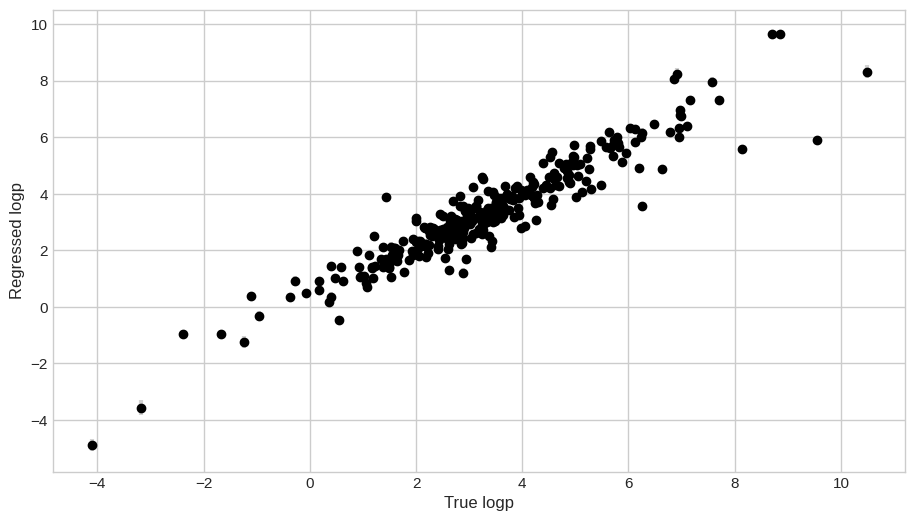

In [ ]:
# uncertainties are shown as gray error bars
get_due_plot(coati_logp_res, y_field="logp")

<ipython-input-30-0b1156e532ac>:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


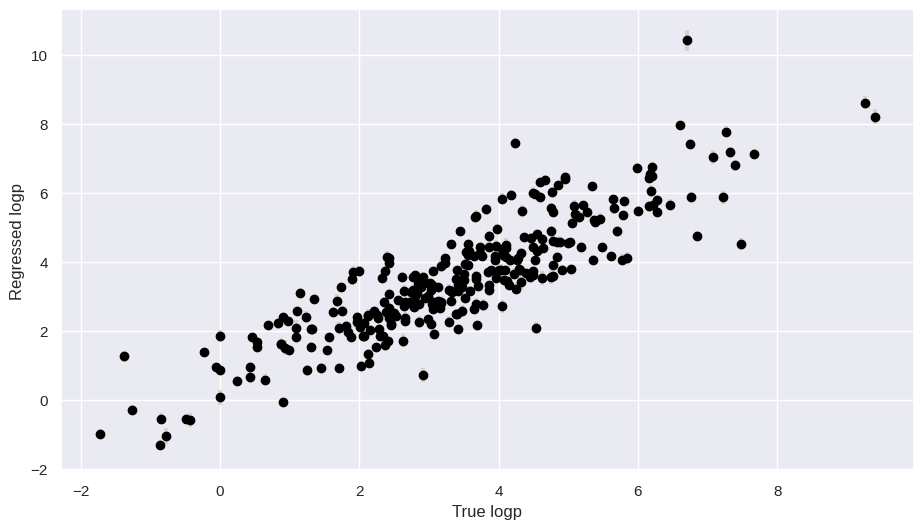

In [ ]:
get_due_plot(clamp_logp_res, y_field="logp")

In [ ]:
# Let's classify the top 95 percentile of logP scores as hits and generate a ROC
# curve for the model's ability to predict hits.
get_roc_plot(coati_logp_res, hit_pct=95)

alt.Chart(...)

In [ ]:
get_roc_plot(clamp_logp_res, hit_pct=95)

alt.Chart(...)

# Linear Probing Code of CLAMP
To download the preprocessed downstream datasets call

In [14]:
!wget -N -r https://cloud.ml.jku.at/s/pyJMm4yQeWFM2gG/download -O downstream.zip
!unzip downstream.zip; rm downstream.zip

will be placed in the single file you specified.

for details.

--2024-06-17 10:28:12--  https://cloud.ml.jku.at/s/pyJMm4yQeWFM2gG/download
Resolving cloud.ml.jku.at (cloud.ml.jku.at)... 140.78.90.41
Connecting to cloud.ml.jku.at (cloud.ml.jku.at)|140.78.90.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14101780 (13M) [application/zip]
Saving to: ‘downstream.zip’

downstream.zip      100%[===================>]  13.45M  11.3MB/s    in 1.2s    

2024-06-17 10:28:14 (11.3 MB/s) - ‘downstream.zip’ saved [14101780/14101780]

FINISHED --2024-06-17 10:28:14--
Total wall clock time: 1.7s
Downloaded: 1 files, 13M in 1.2s (11.3 MB/s)
Archive:  downstream.zip
 extracting: data/downstream/toxcast/activity.parquet  
 extracting: data/downstream/toxcast/compound_names.parquet  
 extracting: data/downstream/toxcast/assay_names.parquet  
 extracting: data/downstream/toxcast/compound_smiles.parquet  
 extracting: data/downstream/bbbp/activity.parquet  
 extracting: data/do

In [16]:
import pandas as pd
dset = './data/downstream/tox21'
smis_df = pd.read_parquet(f'{dset}/compound_smiles.parquet') #assume one on one mapping
act_df = pd.read_parquet(f'{dset}/activity.parquet')
act_df = act_df[act_df.assay_idx==0] # for demo only first assay

In [26]:
def embed_in_batches(
    smiles,
    model_name='coati',
    encoder=coati_encoder,
    tokenizer=coati_tokenizer,
    batch_size=128,
):

    print("Embedding iterable from smiles.")
    batch_iter = batch_indexable(smiles, batch_size)
    num_batches = len(smiles) // batch_size
    with torch.no_grad():
        for i, batch in enumerate(batch_iter):
            print(f"batch: {i}/{num_batches}")
            if model_name == 'coati':
              try:
                  batch_mols = [Chem.MolFromSmiles(row) for row in batch]
                  batch_smiles = [Chem.MolToSmiles(m) for m in batch_mols]
                  batch_tokens = torch.tensor(
                      [
                          tokenizer.tokenize_text("[SMILES]" + s + "[STOP]", pad=True)
                          if s != "*"
                          else tokenizer.tokenize_text("[SMILES]C[STOP]", pad=True)
                          for s in batch_smiles
                      ],
                      device=encoder.device,
                      dtype=torch.int,
                  )
                  #print(batch_tokens[0])
                  batch_embeds = encoder.encode_tokens(batch_tokens, tokenizer)
                  #print(batch_embeds[0]) #1x256

                  if len(batch) < 2:
                      batch[0]["emb_smiles"] = batch_embeds[0].detach().cpu().numpy()
                      batch[0]["smiles"] = batch_smiles[0]
                  else:
                      for k, r in enumerate(batch):
                          batch[k]["emb_smiles"] = batch_embeds[k].detach().cpu().numpy()
                          batch[k]["smiles"] = batch_smiles[k]
              except Exception as Ex:
                  print(Ex)
                  continue

            if model_name == 'clamp':
              try:
                  batch_mols = [Chem.MolFromSmiles(row) for row in batch]
                  batch_smiles = [Chem.MolToSmiles(m) for m in batch_mols]
                  batch_tokens = [s if s != '*' else 'C' for s in batch_smiles]
                  batch_embeds = encoder.encode_smiles(batch_tokens)
                  #print(batch_embeds[0]) #1x768
                  
                  if len(batch) < 2:
                      batch[0]["emb_smiles"] = batch_embeds[0].detach().cpu().numpy()
                      batch[0]["smiles"] = batch_smiles[0]
                  else:
                      for k, r in enumerate(batch):
                          batch[k]["emb_smiles"] = batch_embeds[k].detach().cpu().numpy()
                          batch[k]["smiles"] = batch_smiles[k]
              except Exception as Ex:
                  print(Ex)
                  continue

    return smiles

In [27]:
clamp_encoding = embed_in_batches(smis_df.CanonicalSMILES, 'clamp', clamp_model)
coati_encoding = embed_in_batches(smis_df.CanonicalSMILES, 'coati', coati_encoder, coati_tokenizer)

Embedding iterable from smiles.
batch: 0/61
'str' object does not support item assignment
batch: 1/61
0
batch: 2/61
0
batch: 3/61


0
batch: 4/61
0
batch: 5/61
0
batch: 6/61
0
batch: 7/61
0
batch: 8/61
0
batch: 9/61
0
batch: 10/61
0
batch: 11/61
0
batch: 12/61
0
batch: 13/61
0
batch: 14/61
0
batch: 15/61
0
batch: 16/61
0
batch: 17/61
0
batch: 18/61
0
batch: 19/61
0
batch: 20/61
0
batch: 21/61
0
batch: 22/61
0
batch: 23/61
0
batch: 24/61
0
batch: 25/61
0
batch: 26/61
0
batch: 27/61
0
batch: 28/61
0
batch: 29/61
0
batch: 30/61
0
batch: 31/61
0
batch: 32/61
0
batch: 33/61
0
batch: 34/61
0
batch: 35/61
0
batch: 36/61
0
batch: 37/61
0
batch: 38/61
0
batch: 39/61
0
batch: 40/61
0
batch: 41/61
0
batch: 42/61
0
batch: 43/61
0
batch: 44/61
0
batch: 45/61
0
batch: 46/61
0
batch: 47/61
0
batch: 48/61
0
batch: 49/61
0
batch: 50/61
0
batch: 51/61
0
batch: 52/61
0
batch: 53/61
0
batch: 54/61
0
batch: 55/61
0
batch: 56/61
0
batch: 57/61
0
batch: 58/61
0
batch: 59/61
0
batch: 60/61
0
batch: 61/61
0
Embedding iterable from smiles.
batch: 0/61
tokenize text exception...  [SMILES]CCCCCCCC(=O)[O-].CCCCCCCC(=O)[O-].[Zn+2][STOP] '.' ['[

In [29]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score

def davgp_score(y_true, y_pred, sample_weight=None):
    avgp = average_precision_score(y_true, y_pred, sample_weight=sample_weight)
    y_avg = np.average(y_true, weights=sample_weight)
    return avgp - y_avg

clf = LogisticRegression(max_iter=1500, class_weight='balanced', C=1, random_state=70135)

encodings = {'CLAMP':clamp_encoding["emb_smiles"], 'COATI':coati_encoding["emb_smiles"]}

for name, encoding in encodings.items():
  X_train = encoding[act_df[act_df.scaffold_split=='train'].compound_idx.values]
  y_train = act_df[act_df.scaffold_split=='train'].activity

  X_test = encoding[act_df[act_df.scaffold_split=='test'].compound_idx.values]
  y_test = act_df[act_df.scaffold_split=='test'].activity

  clf.fit(X_train, y_train)

  y_pred = clf.predict_proba(X_test)[:,1]

  print(f'{name}:\t dAP={davgp_score(y_test, y_pred):2.3f}, AUROC={roc_auc_score(y_test, y_pred):2.3f}')

KeyError: 'emb_smiles'